<a href="https://colab.research.google.com/github/gnomez1208/gnomez1208/blob/Dark-Matter-Research/Copy_of_LDR_2_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install uproot

from google.colab import files

print("Please select 'output03048 (1).root' from your Ubuntu machine.")
uploaded = files.upload()
#saved onto google colab local file environment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.6/384.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.5/888.5 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.8/655.8 kB 45.4 MB/s eta 0:00:00
Please select 'output03048 (1).root' from your Ubuntu machine.


Saving output03048 (1).root to output03048 (1).root


Analyzing 5205 waveforms by integrating the filtered signal...

Analysis complete.
Found 612 clean single-peak (SPE) events.
Generated 867 pedestal events from quiet waveforms.
Total events for fitting: 1479

--- Final SPE Calibration Results ---
Pedestal Charge Peak: -22.46 ADC*samples
1 PE Charge Peak:     495.47 ADC*samples
1 PE Charge Sigma:    141.50 ADC*samples
Separation (S/N):     2.97


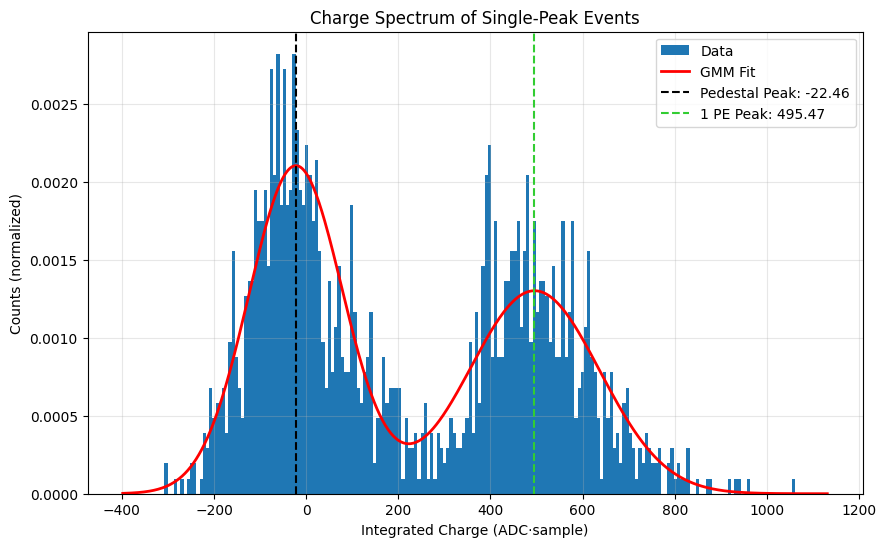

In [2]:

import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = "/content/output03048 (1).root"

# Main Analysis Code
# =========================================================

#Analysis Parameters
sampling_frequency = 250e6  # 250 MHz

# Baseline and Noise
pre_ns = 500  # ns of pre-trigger region for baseline calculation
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)

# Bandpass filter for finding peaks (not using it for integration this time)
bp_lo, bp_hi = 2e6, 35e6  # 1 MHz to 50 MHz
b, a = butter(2, [bp_lo / (sampling_frequency / 2), bp_hi / (sampling_frequency / 2)], btype="band")

# Peak selection criteria/ "the pretty ones"
min_width_ns, max_width_ns = 12, 200  # Pulse width in ns
min_width = max(1, int(min_width_ns * 1e-9 * sampling_frequency))
max_width = int(max_width_ns * 1e-9 * sampling_frequency)
prom_sigma = 4  # Prominence threshold in units of noise sigma|making it super high to truly clean out any noise compared to previous lower sigmas

# Integration window relative to the peak location
int_pre_ns, int_post_ns = 8, 20  # ns before and after the peak, changed to 40 from 100!!!
int_pre = int(int_pre_ns * 1e-9 * sampling_frequency)
int_post = int(int_post_ns * 1e-9 * sampling_frequency)

# Pile-up rejection
refractory_ns = 200  #isolated peaks
'''^ double check the SiPM recharge time '''
refractory = int(refractory_ns * 1e-9 * sampling_frequency)

# Find Peaks
#=================================

def baseline_stats(x, pre=pre_samp):
    """Robust baseline and noise estimation using median and MAD."""
    r = x[:pre]
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    sigma = 1.4826 * mad if mad > 0 else np.std(r) #assuming normal distribution with 1.48 * MAD
    return med, sigma

def detect_peaks(x_raw):
    """Finds clean, isolated peaks in a single waveform."""
    base, sig = baseline_stats(x_raw)
    x0 = x_raw - base
    # Use a bandpass filter only for reliable peak *detection*
    xf = filtfilt(b, a, x0) if len(x0) > 3 * max(1, min_width) else x0

    peaks, _ = find_peaks(
        -xf,  # Invert for negative pulses
        prominence=prom_sigma * sig,
        width=(min_width, max_width)
    )

    # Applying the refractory period to reject pile-up
    if len(peaks) > 1:
        keep = [peaks[0]]
        for p in peaks[1:]:
            if p - keep[-1] >= refractory:
                keep.append(p)
        peaks = np.array(keep, dtype=int)

    return peaks, base

def integrate_charge_filtered(x_filtered, peak_idx):
    """Integrates the charge of a single peak on the CLEAN, FILTERED data."""
    a = max(0, peak_idx - int_pre)
    b = min(len(x_filtered), peak_idx + int_post)
    q = np.trapezoid(x_filtered[a:b])
    return -q # Invert back to get a positive charge

#  Global Analysis Loop (Integrating Filtered Waveform)
# =========================================================
spe_charges = []
pedestal_charges = []
all_heights = []
num_waveforms_to_process = 5205 # all wvfs

with uproot.open(file_path) as file:
    keys = file.keys()
    waveforms_to_process = min(num_waveforms_to_process, len(keys))

    print(f"Analyzing {waveforms_to_process} waveforms by integrating the filtered signal...")

    for i in range(waveforms_to_process):
        waveform_np = file[keys[i]].values()
        base, sig = baseline_stats(waveform_np)

        # Create the clean, filtered waveform
        x0 = waveform_np - base
        xf = filtfilt(b, a, x0)

        # Find peaks on the INVERTED filtered waveform
        peaks, _ = find_peaks(-xf, prominence=prom_sigma * sig, width=(min_width, max_width))

        # Pile-up rejection (remains the same)
        if len(peaks) > 1:
            keep = [peaks[0]]
            for p in peaks[1:]:
                if p - keep[-1] >= refractory:
                    keep.append(p)
            peaks = np.array(keep, dtype=int)

        # CASE 1: Exactly one clean peak was found
        if len(peaks) == 1:
            peak_idx = peaks[0]
            # Use our NEW function on the filtered data
            q = integrate_charge_filtered(xf, peak_idx)
            if q > 0:
                spe_charges.append(q)
                all_heights.append(-xf[peak_idx]) # Height is from filtered data

        # CASE 2: No peaks were found (Forced Trigger)
        elif len(peaks) == 0:
            rand_idx = np.random.randint(len(xf) - (int_pre + int_post))
            trigger_idx = rand_idx + int_pre
            q_ped = integrate_charge_filtered(xf, trigger_idx)
            pedestal_charges.append(q_ped)

# --- The rest of your code (combining lists, GMM, plotting) stays the same ---
# ...

# --- Combine the two lists for the final analysis ---
spe_charges = np.array(spe_charges)
pedestal_charges = np.array(pedestal_charges)
all_charges = np.concatenate([spe_charges, pedestal_charges])

print(f"\nAnalysis complete.")
print(f"Found {len(spe_charges)} clean single-peak (SPE) events.")
print(f"Generated {len(pedestal_charges)} pedestal events from quiet waveforms.")
print(f"Total events for fitting: {len(all_charges)}")


# --- Fit the charge spectrum with a Gaussian Mixture Model ---
if len(all_charges) > 100:
    X = all_charges.reshape(-1, 1)
    # Fit TWO Gaussians: one for the pedestal (noise), one for the 1 PE peak
    gmm = GaussianMixture(n_components=2, random_state=0).fit(X)

    # Sort components by mean to identify pedestal and 1 PE
    means = gmm.means_.flatten()
    covs = gmm.covariances_.flatten() #.flatten ~ make sure it's one dimensional
    sort_idx = np.argsort(means) #creates fresh assorted index
    ped_mu, one_mu = means[sort_idx]
    ped_sigma, one_sigma = np.sqrt(covs[sort_idx])

    # Calculate signal-to-noise for the 1 PE peak for diagnostics
    '''this ratio should be greater than 1, the closer it is to 1 the less accurate'''
    separation = (one_mu - ped_mu) / np.sqrt(ped_sigma**2 + one_sigma**2)

    print(f"\n--- Final SPE Calibration Results ---")
    print(f"Pedestal Charge Peak: {ped_mu:.2f} ADC*samples")
    print(f"1 PE Charge Peak:     {one_mu:.2f} ADC*samples")
    print(f"1 PE Charge Sigma:    {one_sigma:.2f} ADC*samples")
    print(f"Separation (S/N):     {separation:.2f}")

    # Plot the Final Charge Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_charges, bins=200, range=(ped_mu - 3*ped_sigma, one_mu + 4*one_sigma), density=True, label="Data")

    # Plot the GMM fit
    x_fit = np.linspace(plt.xlim()[0], plt.xlim()[1], 500).reshape(-1, 1)
    logprob = gmm.score_samples(x_fit)
    plt.plot(x_fit, np.exp(logprob), color='red', lw=2, label='GMM Fit')

    #add vertical lines at the peaks
    plt.axvline(ped_mu, color='black', linestyle='--', label=f'Pedestal Peak: {ped_mu:.2f}')
    plt.axvline(one_mu, color='limegreen', linestyle='--', label=f'1 PE Peak: {one_mu:.2f}')

    plt.xlabel("Integrated Charge (ADC·sample)")
    plt.ylabel("Counts (normalized)")
    plt.title("Charge Spectrum of Single-Peak Events")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

else:
    print("\nCould not find enough single-peak events to perform a reliable fit.")

##**Pulse Height Histogram**

Pulse Height Diagnostic
Number of heights found: 612
Min. Height: 49.74362758735013
Max. Height: 194.48499494008297
Mean Height: 93.35714441033083
Number of negative heights: 0
Plotting histogram, gimme a sec...


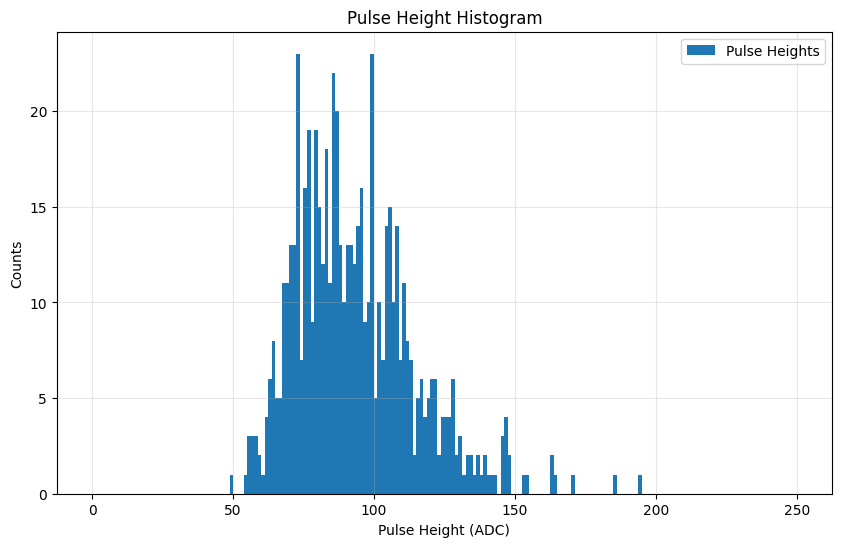

In [3]:
all_heights_np = np.array(all_heights)

if len(all_heights) > 0:
  print("Pulse Height Diagnostic")
  print(f"Number of heights found: {len(all_heights_np)}")
  print(f"Min. Height: {np.min(all_heights_np)}")
  print(f"Max. Height: {np.max(all_heights_np)}")
  print(f"Mean Height: {np.mean(all_heights_np)}")

  num_negative = np.sum(all_heights_np < 0)
  print(f"Number of negative heights: {num_negative}")
else:
  print("No pulse heights found. 'all_heights' is empty.")

if len(all_heights) > 100:
  print("Plotting histogram, gimme a sec...")

  plt.figure(figsize=(10, 6))
  plt.hist(all_heights,
           bins=200,
           range=(0,250),
           label = "Pulse Heights"
  )

  plt.xlabel("Pulse Height (ADC)")
  plt.ylabel("Counts")
  plt.title("Pulse Height Histogram")
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

else:
  print("\nCould not find enough single-peak events to create histogram.")

##**Global Average SPE Pulse Template**


In [4]:

print("Generating a global SPE pulse template...")

all_clean_pulses = []
num_waveforms_for_template = 5205 # All waveforms

with uproot.open(file_path) as file:
    keys = file.keys()
    for i in range(min(num_waveforms_for_template, len(keys))):
        waveform_np = file[keys[i]].values()
        baseline, sigma = baseline_stats(waveform_np)

        #filtered waveforms we want to find peaks from
        x0 = waveform_np - baseline
        xf = filtfilt(b, a, x0)

        # Find very clean, isolated peaks for the template
        peaks, _ = find_peaks(
            -xf,
            prominence=(5 * sigma), # strict prominence
            distance=100 # Well-separated peaks?
        )

        # "Cut out" each clean pulse and add it to our list
        for p in peaks:
            start, end = p - 20, p + 20 # Define a 40-sample window
            if start > 0 and end < len(xf):
                pulse_slice = (xf)[start:end]
                all_clean_pulses.append(pulse_slice)

# Average all the collected pulses together to form global pulse template
if len(all_clean_pulses) > 10: # Ensure we found enough pulses

    aligned_pulses = []
    for pulse in all_clean_pulses:
        peak_idx = np.argmin(pulse)
        shift = 20 - peak_idx
        aligned = np.roll(pulse, shift)
        aligned_pulses.append(aligned)

    global_avg_template = np.mean(aligned_pulses, axis=0)

    global_avg_template /= abs(np.min(global_avg_template))  # normalize

    '''global_avg_template = np.mean(all_clean_pulses, axis=0)'''

    print(f"Successfully created a global template from {len(all_clean_pulses)} aligned_pulses.")
else:
    print("Warning: Could not find enough clean pulses for a global template.")
    # As a fallback
    x = np.linspace(-5, 5, 40)
    global_avg_template = -15 * np.exp(-x**2 / 4)
    global_avg_template /= np.min(global_avg_template) #normalize fallback as well


print("Template Diagnostics:")
print(f"Template Min: {np.min(global_avg_template)}") #should be -1 after normalization
print(f"Template Max: {np.max(global_avg_template)}") # should be 1 after normalization
print(f"Template Charge: {-np.sum(global_avg_template)}")


Generating a global SPE pulse template...
Successfully created a global template from 13700 aligned_pulses.
Template Diagnostics:
Template Min: -1.0
Template Max: 0.27084873651521285
Template Charge: 7.773035056708553


##**Plotting the Waveform w/Approx SPE Levels**

In [5]:
# Cell to Plot Raw Waveform with Approximate PE Height Lines (Flipped)

import plotly.graph_objects as go

# 1. Select a waveform to inspect
#=========================================
waveform_index_to_plot = 2100 # You can change this index

with uproot.open(file_path) as file:
    keys = file.keys()
    # THIS IS THE FIX: Select the key first, then get the values.
    waveform_np = file[keys[waveform_index_to_plot]].values()

    df_single = pd.DataFrame({'Raw ADC': waveform_np})
    df_single['Time (ns)'] = np.arange(len(df_single)) * 4.0

# 2. Calculate an "Effective SPE Height"
#=============================================

# Translate global charge value (one_mu) into an approximate height
baseline, sigma = baseline_stats(waveform_np)

# Use the pre-computed global template to find the charge-to-height ratio.
template_charge = -np.sum(global_avg_template) # Area of the global template
template_height = -np.min(global_avg_template) # Height of the global template (will be 1)

# Scale the template height by the ratio of the "true" SPE charge to the template charge
effective_spe_height = template_height * (one_mu / template_charge)

print(f"Visualization Parameters")
print(f"Global SPE Charge (one_mu): {one_mu:.2f}")
print(f"Effective Global SPE Height: {effective_spe_height:.2f} ADC counts")

# 3. Plot
fig_approx = go.Figure()


# Add raw waveform trace
fig_approx.add_trace(go.Scatter(
    x=df_single['Time (ns)'], y=df_single['Raw ADC'],
    name='Raw Waveform', mode='lines'
))

# Add horizontal lines for SPE levels on the RAW waveform scale
fig_approx.add_hline(y=baseline, line_dash="dot", line_color="grey", annotation_text="Baseline")
fig_approx.add_hline(y=baseline - effective_spe_height, line_dash="solid", line_color="springgreen", annotation_text="1 PE Level (Approx.)")
fig_approx.add_hline(y=baseline - 2 * effective_spe_height, line_dash="dash", line_color="gold", annotation_text="2 PE Level (Approx.)")
fig_approx.add_hline(y=baseline - 3 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="3 PE Level (Approx.)")
#fig_approx.add_hline(y=baseline - 4 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="4 PE Level (Approx.)")
#fig_approx.add_hline(y=baseline - 5 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="5 PE Level (Approx.)")
#fig_approx.add_hline(y=baseline - 6 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="6 PE Level (Approx.)")
#fig_approx.add_hline(y=baseline - 8 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="8 PE Level (Approx.)")
#fig_approx.add_hline(y=baseline - 10 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="10 PE Level (Approx.)")

fig_approx.update_layout(
    title_text=f"Raw Waveform with Approximate SPE Levels (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="Raw ADC Value",
    yaxis=dict(autorange='reversed')
)

fig_approx.show()


Visualization Parameters
Global SPE Charge (one_mu): 495.47
Effective Global SPE Height: 63.74 ADC counts


In [6]:
# Cell to Plot Raw Waveform with Approximate PE Height Lines (Flipped)
import plotly.graph_objects as go

# 1. Select a waveform to inspect
#=========================================
waveform_index_to_plot = 520
with uproot.open(file_path) as file:
    waveform_np = file[file.keys()[waveform_index_to_plot]].values()
    df_single = pd.DataFrame({'Raw ADC': waveform_np})
    df_single['Time (ns)'] = np.arange(len(df_single)) * 4.0

# 2. Calculate the "Effective SPE Height"
#=============================================
baseline, sigma = baseline_stats(waveform_np)

# Get properties from our perfectly normalized template
template_charge = -np.sum(global_avg_template)
# The amplitude of the normalized template pulse is 1.0
template_amplitude = 1.0

# Calculate the height corresponding to the crosstalk charge (one_mu)
effective_2pe_height = template_amplitude * (one_mu / template_charge)

# The true 1 PE height is half of the 2 PE crosstalk height
effective_1pe_height = effective_2pe_height / 2

print(f"\n--- Final Visualization Parameters ---")
print(f"Crosstalk Charge (one_mu from fit): {one_mu:.2f}")
print(f"Calculated 2 PE Height: {effective_2pe_height:.2f} ADC counts")
print(f"Final 1 PE Height:      {effective_1pe_height:.2f} ADC counts")

# 3. Plot using the final, corrected 1 PE height
#=================================================
fig_approx = go.Figure()
fig_approx.add_trace(go.Scatter(
    x=df_single['Time (ns)'], y=df_single['Raw ADC'],
    name='Raw Waveform', mode='lines'
))
fig_approx.add_hline(y=baseline, line_dash="dot", line_color="grey", annotation_text="Baseline")
fig_approx.add_hline(y=baseline - effective_1pe_height, line_dash="solid", line_color="springgreen", annotation_text="1 PE Level")
fig_approx.add_hline(y=baseline - 2 * effective_1pe_height, line_dash="dash", line_color="gold", annotation_text="2 PE Level")
fig_approx.add_hline(y=baseline - 3 * effective_1pe_height, line_dash="dash", line_color="orange", annotation_text="3 PE Level")
fig_approx.add_hline(y=baseline - 4 * effective_1pe_height, line_dash="dash", line_color="orange", annotation_text="4 PE Level")
fig_approx.add_hline(y=baseline - 5 * effective_1pe_height, line_dash="dash", line_color="orange", annotation_text="5 PE Level")

fig_approx.update_layout(
    title_text=f"Raw Waveform with Approximate SPE Levels (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)", yaxis_title="Raw ADC Value", yaxis=dict(autorange='reversed'))
fig_approx.show()


--- Final Visualization Parameters ---
Crosstalk Charge (one_mu from fit): 495.47
Calculated 2 PE Height: 63.74 ADC counts
Final 1 PE Height:      31.87 ADC counts


In [7]:
print(f"\n--- Final SPE Calibration Results ---")
print(f"Pedestal Charge Peak: {ped_mu:.2f} ADC*samples")
print(f"1 PE Charge Peak:     {one_mu:.2f} ADC*samples")
print(f"1 PE Charge Sigma:    {one_sigma:.2f} ADC*samples")
print(f"Separation (S/N):     {separation:.2f}")
print('----------------------------')
print("--- Pulse Height Diagnostic ---")
print(f"Number of heights found: {len(all_heights_np)}")
print(f"Min. Height: {np.min(all_heights_np)}")
print(f"Max. Height: {np.max(all_heights_np)}")
print(f"Mean Height: {np.mean(all_heights_np)}")
print('----------------------------')
print(f"--- Visualization Parameters ---")
print(f"Global SPE Charge (one_mu): {one_mu:.2f}")
print(f"Effective Global SPE Height: {effective_spe_height:.2f} ADC counts")



--- Final SPE Calibration Results ---
Pedestal Charge Peak: -22.46 ADC*samples
1 PE Charge Peak:     495.47 ADC*samples
1 PE Charge Sigma:    141.50 ADC*samples
Separation (S/N):     2.97
----------------------------
--- Pulse Height Diagnostic ---
Number of heights found: 612
Min. Height: 49.74362758735013
Max. Height: 194.48499494008297
Mean Height: 93.35714441033083
----------------------------
--- Visualization Parameters ---
Global SPE Charge (one_mu): 495.47
Effective Global SPE Height: 63.74 ADC counts


#**Another Raw Waveform to Plot**


In [9]:

waveform_index_to_plot2 = 520

with uproot.open(file_path) as file:
    keys = file.keys()
    # THIS IS THE FIX: Select the key first, then get the values.
    waveform_np2 = file[keys[waveform_index_to_plot2]].values()

    df_single = pd.DataFrame({'Raw ADC': waveform_np2})
    df_single['Time (ns)'] = np.arange(len(df_single)) * 4.0

# 2. Calculate an "Effective SPE Height"
#=============================================

# This translates your global charge value (one_mu) into an approximate height.
baseline, sigma = baseline_stats(waveform_np2)

# INSTEAD using the pre-computed global template to find the charge-to-height ratio.
template_charge = -np.sum(global_avg_template) # Area of the global template
template_height = -np.min(global_avg_template) # Height of the global template (will be 1)

# Scale the template height by the ratio of the true SPE charge to the template charge
effective_spe_height = template_height/2 * (one_mu / template_charge)

print(f"Visualization Parameters")
print(f"Global SPE Charge (one_mu): {one_mu:.2f}")
print(f"Effective Global SPE Height: {effective_spe_height:.2f} ADC counts")

# 3. Plot
#=========================================================
fig_approx2 = go.Figure()


# Add the raw waveform trace
fig_approx2.add_trace(go.Scatter(
    x=df_single['Time (ns)'], y=df_single['Raw ADC'],
    name='Raw Waveform', mode='lines'
))

# Add horizontal lines on the RAW waveform scale
fig_approx2.add_hline(y=baseline, line_dash="dot", line_color="grey", annotation_text="Baseline")
fig_approx2.add_hline(y=baseline - effective_spe_height, line_dash="solid", line_color="springgreen", annotation_text="1 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 2 * effective_spe_height, line_dash="dash", line_color="gold", annotation_text="2 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 3 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="3 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 4 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="4 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 5 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="5 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 6 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="6 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 8 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="8 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 10 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="10 PE Level (Approx.)")

fig_approx2.update_layout(
    title_text=f"Raw Waveform with Approximate SPE Levels (Waveform #{waveform_index_to_plot2})",
    xaxis_title="Time (ns)",
    yaxis_title="Raw ADC Value",
    yaxis=dict(autorange='reversed')
)

fig_approx2.show()


Visualization Parameters
Global SPE Charge (one_mu): 495.47
Effective Global SPE Height: 31.87 ADC counts


In [10]:

waveform_index_to_plot2 = 897

with uproot.open(file_path) as file:
    keys = file.keys()
    # THIS IS THE FIX: Select the key first, then get the values.
    waveform_np2 = file[keys[waveform_index_to_plot2]].values()

    df_single = pd.DataFrame({'Raw ADC': waveform_np2})
    df_single['Time (ns)'] = np.arange(len(df_single)) * 4.0

# 2. Calculate an "Effective SPE Height"
#=============================================

# This translates your global charge value (one_mu) into an approximate height.
baseline, sigma = baseline_stats(waveform_np2)

# INSTEAD using the pre-computed global template to find the charge-to-height ratio.
template_charge = -np.sum(global_avg_template) # Area of the global template
template_height = -np.min(global_avg_template) # Height of the global template (will be 1)

# Scale the template height by the ratio of the true SPE charge to the template charge
effective_spe_height = template_height/2 * (one_mu / template_charge)

print(f"Visualization Parameters")
print(f"Global SPE Charge (one_mu): {one_mu:.2f}")
print(f"Effective Global SPE Height: {effective_spe_height:.2f} ADC counts")

# 3. Plot
#=========================================================
fig_approx2 = go.Figure()


# Add the raw waveform trace
fig_approx2.add_trace(go.Scatter(
    x=df_single['Time (ns)'], y=df_single['Raw ADC'],
    name='Raw Waveform', mode='lines'
))

# Add horizontal lines on the RAW waveform scale
fig_approx2.add_hline(y=baseline, line_dash="dot", line_color="grey", annotation_text="Baseline")
fig_approx2.add_hline(y=baseline - effective_spe_height, line_dash="solid", line_color="springgreen", annotation_text="1 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 2 * effective_spe_height, line_dash="dash", line_color="gold", annotation_text="2 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 3 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="3 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 4 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="4 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 5 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="5 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 6 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="6 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 8 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="8 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 10 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="10 PE Level (Approx.)")

fig_approx2.update_layout(
    title_text=f"Raw Waveform with Approximate SPE Levels (Waveform #{waveform_index_to_plot2})",
    xaxis_title="Time (ns)",
    yaxis_title="Raw ADC Value",
    yaxis=dict(autorange='reversed')
)

fig_approx2.show()


Visualization Parameters
Global SPE Charge (one_mu): 495.47
Effective Global SPE Height: 31.87 ADC counts


In [ ]:

waveform_index_to_plot2 = 866

with uproot.open(file_path) as file:
    keys = file.keys()
    # THIS IS THE FIX: Select the key first, then get the values.
    waveform_np2 = file[keys[waveform_index_to_plot2]].values()

    df_single = pd.DataFrame({'Raw ADC': waveform_np2})
    df_single['Time (ns)'] = np.arange(len(df_single)) * 4.0

# 2. Calculate an "Effective SPE Height"
#=============================================

# This translates your global charge value (one_mu) into an approximate height.
baseline, sigma = baseline_stats(waveform_np2)

# INSTEAD using the pre-computed global template to find the charge-to-height ratio.
template_charge = -np.sum(global_avg_template) # Area of the global template
template_height = -np.min(global_avg_template) # Height of the global template (will be 1)

# Scale the template height by the ratio of the true SPE charge to the template charge
effective_spe_height = template_height * (one_mu / template_charge)

print(f"Visualization Parameters")
print(f"Global SPE Charge (one_mu): {one_mu:.2f}")
print(f"Effective Global SPE Height: {effective_spe_height:.2f} ADC counts")

# 3. Plot
#=========================================================
fig_approx2 = go.Figure()


# Add the raw waveform trace
fig_approx2.add_trace(go.Scatter(
    x=df_single['Time (ns)'], y=df_single['Raw ADC'],
    name='Raw Waveform', mode='lines'
))

# Add horizontal lines on the RAW waveform scale
fig_approx2.add_hline(y=baseline, line_dash="dot", line_color="grey", annotation_text="Baseline")
fig_approx2.add_hline(y=baseline - effective_spe_height, line_dash="solid", line_color="springgreen", annotation_text="1 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 2 * effective_spe_height, line_dash="dash", line_color="gold", annotation_text="2 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 3 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="3 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 4 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="4 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 5 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="5 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 6 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="6 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 8 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="8 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 10 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="10 PE Level (Approx.)")

fig_approx2.update_layout(
    title_text=f"Raw Waveform with Approximate SPE Levels (Waveform #{waveform_index_to_plot2})",
    xaxis_title="Time (ns)",
    yaxis_title="Raw ADC Value",
    yaxis=dict(autorange='reversed')
)

fig_approx2.show()


Visualization Parameters
Global SPE Charge (one_mu): 495.93
Effective Global SPE Height: 63.80 ADC counts


In [ ]:

waveform_index_to_plot2 = 810

with uproot.open(file_path) as file:
    keys = file.keys()
    # THIS IS THE FIX: Select the key first, then get the values.
    waveform_np2 = file[keys[waveform_index_to_plot2]].values()

    df_single = pd.DataFrame({'Raw ADC': waveform_np2})
    df_single['Time (ns)'] = np.arange(len(df_single)) * 4.0

# 2. Calculate an "Effective SPE Height"
#=============================================

# This translates your global charge value (one_mu) into an approximate height.
baseline, sigma = baseline_stats(waveform_np2)

# INSTEAD using the pre-computed global template to find the charge-to-height ratio.
template_charge = -np.sum(global_avg_template) # Area of the global template
template_height = -np.min(global_avg_template) # Height of the global template (will be 1)

# Scale the template height by the ratio of the true SPE charge to the template charge
effective_spe_height = template_height * (one_mu / template_charge)

print(f"Visualization Parameters")
print(f"Global SPE Charge (one_mu): {one_mu:.2f}")
print(f"Effective Global SPE Height: {effective_spe_height:.2f} ADC counts")

# 3. Plot
#=========================================================
fig_approx2 = go.Figure()


# Add the raw waveform trace
fig_approx2.add_trace(go.Scatter(
    x=df_single['Time (ns)'], y=df_single['Raw ADC'],
    name='Raw Waveform', mode='lines'
))

# Add horizontal lines on the RAW waveform scale
fig_approx2.add_hline(y=baseline, line_dash="dot", line_color="grey", annotation_text="Baseline")
fig_approx2.add_hline(y=baseline - effective_spe_height, line_dash="solid", line_color="springgreen", annotation_text="1 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 2 * effective_spe_height, line_dash="dash", line_color="gold", annotation_text="2 PE Level (Approx.)")
fig_approx2.add_hline(y=baseline - 3 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="3 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 4 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="4 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 5 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="5 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 6 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="6 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 8 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="8 PE Level (Approx.)")
#fig_approx2.add_hline(y=baseline - 10 * effective_spe_height, line_dash="dash", line_color="orange", annotation_text="10 PE Level (Approx.)")

fig_approx2.update_layout(
    title_text=f"Raw Waveform with Approximate SPE Levels (Waveform #{waveform_index_to_plot2})",
    xaxis_title="Time (ns)",
    yaxis_title="Raw ADC Value",
    yaxis=dict(autorange='reversed')
)

fig_approx2.show()


Visualization Parameters
Global SPE Charge (one_mu): 495.93
Effective Global SPE Height: 63.80 ADC counts
